# Exercise Sheet 3 - Covid-19 Classification using Transfer Learning

- Deep Learning for Computer Vision - Winter Term 2024/25
- Lecture by: Constantin Pape
- Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair
- Due date: **Tuesday**, Dec 3, before 10:00

## Time Required to Solve this Exercise Sheet

As you will train deep CNNs on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.

## Topic

In this exercise, you will solve an image classification task from medical imaging: classification in Chest X-Ray images into patients with Covid-19, Pneunomia or Healthy. We will use a subset of the dataset from a Kaggle challenge for this. (https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia)

The main focus of this exercise is transfer learning and you will approach the classification task with three different approaches:

    Training ResNets from scratch. (Note that we will use the ResNet implementation from torchvision throughout the exercise).
    Training ResNets pretrained on ImageNet.
    Training ResNets pretrained on RadImageNet, a large radiology dataset.

In addition you can combine these approaches with other methods to improve the model at the end and upload your best solution on a hold-out test set. This is explained in more details at the end of the exercise.

### Hints

In the first part of the exercise you will train ResNets from scratch, analyze the effects of deeper models with small training data and use data augmentations. In the second part, you will solve the same task using pretrained ResNets (from ImageNet - pretrained on natural images; and RadImageNet - pretrained on the medical imaging domain).

To understand the background of this exercise, you can:
- Review the lectures
    - Lecture 3 on CNNs
    - Lecture 4 on Transfer Learning and Augmentaion
- Check out the [RadImageNet publication](https://doi.org/10.1148/ryai.210315).

At the end of the exercise you should further improve your model. You can draw upon a number of techniques we discussed for improving model performance. The predictions from your best model on a hold-out test set should be uploaded together with the exercise. More explanation is given at the end of the exercise sheet.

_Do not hesitate to ask questions and ideally discuss them with the fellow students on Matrix! We will monitor the channel to provide you help if your discussions get stuck._

## IMPORTANT SUBMISSION INSTRUCTIONS
- **You need to answer all the questions in written form**
- When you are done, download the notebook from Kaggle and **rename** it to `<surname1>_<surname2>_<surname3>.ipynb`
- For the final submission:
    - Submit the **Jupyter Notebook** (.ipynb file). Upload them on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 3` -> `Notebook` -> `Tutorial <X>` (where, `X` is the tutorial you are assigned to).
    - Submit the **Challenge Results** (.csv file) (for the unlabeled images, namely `unknown`). Upload them on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 3` -> `Challenge Results` -> `Tutorial <X>`
- Make only one submission of the exercise and results per group.
- The deadline is strict.
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand.

Implementation
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs and answer the **questions** asked. In addition to the python packages loaded below, you are allowed to use any packages you want.

**Importing required libraries:**

We have provided the most essential libraries to be used for the exercise. Feel free to add modules as per your requirement.

In [1]:
import os
from glob import glob
from IPython.display import FileLink

import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms

%pip install barbar

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Setting up the device (make sure device returns "cuda" to use of the GPUs on kaggle)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Getting the Required Functionalities

We first download and import `ex3_utils.py`, which in which functions for training evaluation etc. are already implemented (similar to the previous exercise). You can download this file and inspect it on your computer to understand the functions it contains.

You can either download it from google drive as here or from Stud.IP (it's provided there in the same folder as this notebook.)

In [3]:
# DO NOT CHANGE
# Download `ex3_utils.py` from Google Drive in Kaggle
!conda install -y gdown

# File Location - https://drive.google.com/file/d/1VfnvYTwNbDdwFArYZqZuqhkmw9d39IgQ/view?usp=sharing (we only need the id)
!gdown 1VfnvYTwNbDdwFArYZqZuqhkmw9d39IgQ

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.9.2               |  py310hff52083_0         895 KB  conda-forge
    filelock-3.16.1            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.4.0              |       hb9d3cd8_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.16.1-pyhd8ed1ab_0 
  gdown              conda-forg

In [4]:
# DO NOT CHANGE
# Import `ex3_utils.py`
import ex3_utils as utils

### Data Preparation

We download the data from google drive and unzip the data in `"/kaggle/working/covid19"`.

NOTE: If you are working on another system besides Kaggle, you should update the base directory (`/kaggle/working`) to your desired filepath.

In [5]:
# DO NOT CHANGE
# Downloading the "Chest X-ray (Covid-19 & Pneumonia)" data from owncloud
!wget https://owncloud.gwdg.de/index.php/s/dcvhmxtksDDDtK8/download -O covid19-xray.zip

# Unzipping the dataset
!unzip -q "/kaggle/working/covid19-xray.zip"

--2024-11-20 16:41:10--  https://owncloud.gwdg.de/index.php/s/dcvhmxtksDDDtK8/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154704441 (148M) [application/zip]
Saving to: 'covid19-xray.zip'

covid19-xray.zip    100%[===================>] 147.54M  17.7MB/s    in 9.5s    

2024-11-20 16:41:20 (15.6 MB/s) - 'covid19-xray.zip' saved [154704441/154704441]



In [6]:
# DO NOT CHANGE
# Setting the path to covid-19 dataset
root_dir = "/kaggle/working/"
data_folder = os.path.join(root_dir, "covid19")

**Data exploration**

The data is stored in the root folder `covid19` (in `"/kaggle/working"`) and contains four subfolders, namely `train`, `val`, `test` and `unknown` with training / validation / testing split and the hold-out test set, respectively. Each of these (except `unknown`) contains subfolders with the images for the respective classes. As a first step, we will visualize some of the images and labels from the training data.

We will not use the `unknown` directory for training or evaluation, but will only use it for prediction with the best model at the end.

In [7]:
# DO NOT CHANGE
# Checking the number of classes
train_class_dirs = glob(os.path.join(data_folder, "train", "*"))
val_class_dirs = glob(os.path.join(data_folder, "val", "*"))
test_class_dirs = glob(os.path.join(data_folder, "test", "*"))
assert len(train_class_dirs) == len(val_class_dirs) == len(test_class_dirs) == 3

In [8]:
# DO NOT CHANGE
# Checking the expected structure of all images
image_paths = glob(os.path.join(data_folder, "**", "*.jpg"), recursive=True)
assert len(image_paths) == (450 + 150 + 225 + 5607), len(image_paths)  # 450 train samples, 150 val samples, 225 test samples, 5607 unlabeled samples (hold-out test)

Let's plot samples from each class in the training set:

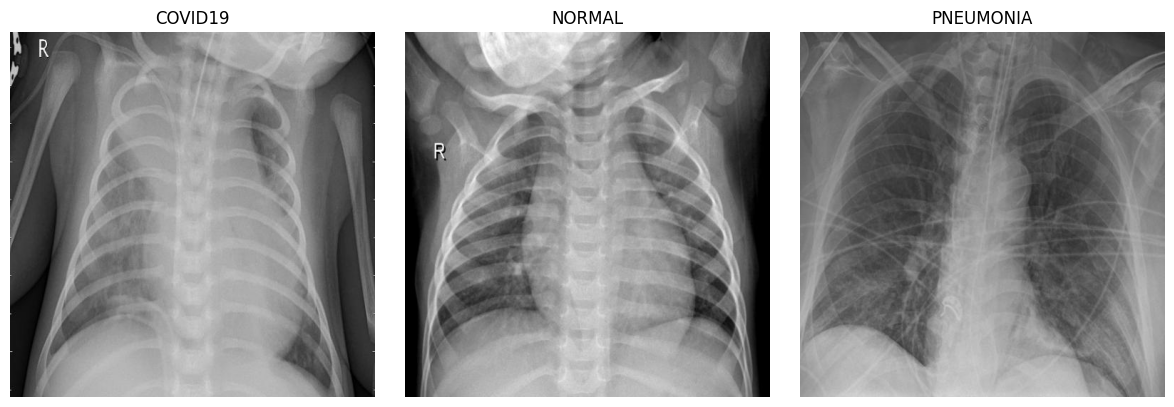

In [9]:
# Classes available for the task
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = 3

# TODO: YOUR SOLUTION HERE
from PIL import Image

def plot_first_image_from_each_class(class_dirs, class_labels):
    plt.figure(figsize=(12, 4))
    for i, class_dir in enumerate(class_dirs):
        images = glob(os.path.join(class_dir, "*.jpg"))
        if images:  # Ensure the directory is not empty
            img_path = images[0]
            img = Image.open(img_path)
            plt.subplot(1, len(class_labels), i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_labels[i])
    plt.tight_layout()
    plt.show()

# Pass training class directories and class labels to the plot function
plot_first_image_from_each_class(train_class_dirs, classes)

In [10]:
import os

# Count the number of images for each class
def count_images_per_class(class_dirs, class_labels):
    counts = {}
    for class_dir, label in zip(class_dirs, class_labels):
        image_files = glob(os.path.join(class_dir, "*.jpg"))
        counts[label] = len(image_files)
    return counts

# Get the counts for the training dataset
train_image_counts = count_images_per_class(train_class_dirs, classes)
val_image_counts = count_images_per_class(val_class_dirs, classes)
test_image_counts = count_images_per_class(test_class_dirs, classes)

# Print the counts
for label, count in train_image_counts.items():
    print(f"Class '{label}': {count} images")
for label, count in val_image_counts.items():
    print(f"Class '{label}': {count} images")
for label, count in test_image_counts.items():
    print(f"Class '{label}': {count} images")

Class 'COVID19': 150 images
Class 'NORMAL': 150 images
Class 'PNEUMONIA': 150 images
Class 'COVID19': 50 images
Class 'NORMAL': 50 images
Class 'PNEUMONIA': 50 images
Class 'COVID19': 75 images
Class 'NORMAL': 75 images
Class 'PNEUMONIA': 75 images


You should see x-ray images from each class and their corresponding labels in their titles. To reflect on our understanding of the dataset, please answer the following **questions**:
- How many classes are provided in the datasets? 3
- Are the images balanced along all the classes in the respective data splits? Yes

Let's set the directories for the respective datasets

In [11]:
# Splits for the dataset 
train_dir = os.path.join(data_folder, "train")
val_dir = os.path.join(data_folder, "val")
test_dir = os.path.join(data_folder, "test")
unknown_dir = os.path.join(data_folder, "unknown")

Now, we obtain the statistics (mean and standard deviation) from the training dataset to be used for normalizing the datasets

In [12]:
# DO NOT CHANGE
train_images = []
for class_name in classes:
    train_images.extend(glob(os.path.join(train_dir, class_name, "*.jpg")))

to_tensor = torchvision.transforms.ToTensor()
imgs = torch.stack([to_tensor(imageio.imread(im)) for im in train_images])
print(imgs.shape)

# And then compute the mean and standard deviation independently for the image channels.
# (The channels are stored in dim=1, by excluding this below we achieve this.)
mean = torch.mean(imgs, dim=(0, 2, 3))
std = torch.std(imgs, dim=(0, 2, 3))

# Delete the images again in order to save memory.
del imgs

print(mean)
print(std)

torch.Size([450, 3, 512, 512])
tensor([0.4949, 0.4952, 0.4957])
tensor([0.2298, 0.2298, 0.2298])


In [13]:
train_dataset_mean = mean
train_dataset_std = std

**Implement PyTorch dataloader**

As a next step, we implement a `torch.utils.data.Dataset` followed by the `torch.utils.data.DataLoader` to have access to our data during training, validation and testing. In our case, the data is stored in a format that is already compatible with `torchvision.datasets.ImageFolder`.

To use the image data in PyTorch it first needs to be transformed. You can use the transformations from [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html) for this. Here, we need to:
- Convert the image data to a `torch.tensor` (`transforms.ToTensor`)
- Standardize the inputs based on their data statistics (`transforms.Normalize`)
- Resize the images (`transforms.Resize`). Note that resizing is not strictly necessary, but will speed up training and resize the images to a size that better matches the ImageNet pretraining data.

To combine several transforms together, you can use `torchvision.transforms.Compose` by passing the list of 'transform' objects to compose.

In [14]:
# We resize the images to the size 256 x 256 to speed up training
height = width = 256

# Get the usual transforms to have the inputs from dataloaders as expected
def get_transforms(height, width):
    # TODO: YOUR CODE HERE
    transform = transforms.Compose([
        transforms.Resize((height, width)),  
        transforms.ToTensor(),              
        transforms.Normalize(               
            mean=train_dataset_mean,   
            std=train_dataset_std      
        )
    ])
    return transform

In [54]:
# Batch size
batch_size = 64  # TODO: YOUR CHOICE HERE

# Datasets
# TODO: YOUR SOLUTION HERE
from torchvision import datasets
from torch.utils.data import DataLoader
transform = get_transforms(height, width)  # Reuse the get_transforms function

data_folder = "path_to_your_dataset"  # Replace with the path to your dataset root
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Dataloaders
# TODO: YOUR SOLUTION HERE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Now let's visualize the images after transformation as they are returned from the training loader.

NORMAL,  NORMAL,  PNEUMONIA,  NORMAL,  NORMAL,  PNEUMONIA,  COVID19,  NORMAL,  PNEUMONIA,  COVID19,  NORMAL,  PNEUMONIA,  PNEUMONIA,  PNEUMONIA,  PNEUMONIA,  PNEUMONIA,  PNEUMONIA,  COVID19,  NORMAL,  PNEUMONIA,  NORMAL,  NORMAL,  COVID19,  COVID19,  COVID19,  PNEUMONIA,  NORMAL,  COVID19,  PNEUMONIA,  COVID19,  COVID19,  PNEUMONIA,  COVID19,  COVID19,  NORMAL,  PNEUMONIA,  COVID19,  COVID19,  PNEUMONIA,  NORMAL,  NORMAL,  COVID19,  NORMAL,  COVID19,  PNEUMONIA,  PNEUMONIA,  PNEUMONIA,  COVID19,  NORMAL,  NORMAL,  COVID19,  NORMAL,  NORMAL,  PNEUMONIA,  COVID19,  PNEUMONIA,  COVID19,  COVID19,  NORMAL,  NORMAL,  NORMAL,  PNEUMONIA,  PNEUMONIA,  NORMAL, 


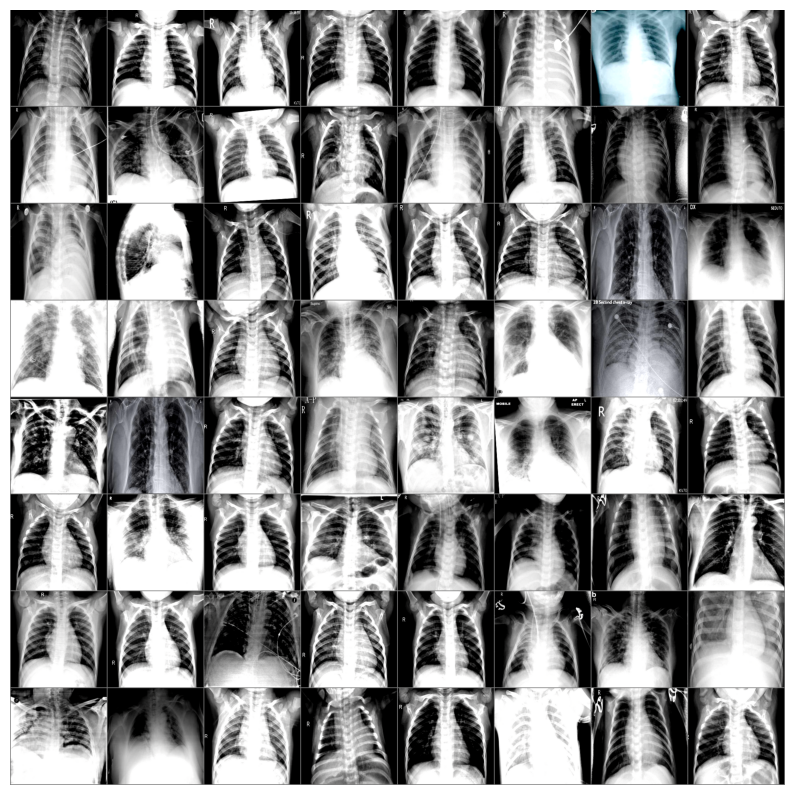

In [16]:
# Function to show images
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5  # unnormalise
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Obtain random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

## Architecture

We will use the ResNet implementation from torchvision, see https://pytorch.org/vision/stable/models.html, for this exercise.

- We start with the smallest ResNet model, the ResNet18 (https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)
- And will then use deeper ResNets to explore how well larger models can be trained on a small dataset.
- To use random weight initialization (in order to train from scratch), you can just create models without passing additional arguments like so: `torchvision.models.<MODEL_NAME>()`.

We need to adapt the model to fit with our purpose. For this, we must change the output dimension of the last fully-connected layer to consider the number of classes in our problem. Let's check the last layer out.

In [17]:
# Let's get the resnet18 architecture and understanding the backbone (in order to adapt it to our problem)
# TODO: YOUR SOLUTION HERE
model = torchvision.models.resnet18()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We see above that there is a component called `fc` that consists of a `Linear` layer. To make use of ResNet18 for our classification task, we need to change the `out_features` of the linear layer to the number of classes of our problem. In our case, it's `num_classes` (=3).

In [18]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


To replace the last layer (classification layer) you can use the following code. (Here we provide a stand-alone code snippet)

```python
import torchvision
import torch.nn as nn

model = torchvision.models.resnet18()

# Let's replace the "fully connected" layer to match our expected output classes
model.fc = nn.Linear(<INPUT_FEATURES>, <OUTPUT_CLASSES>)
model.to(device)
```

In [19]:
# Replacing the last layer(s) of ResNet18 to match our number of classes
# TODO: YOUR SOLUTION HERE
model = torchvision.models.resnet18()
model.fc = nn.Linear(in_features=512, out_features=3)


# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = "3_class_resnet18"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)

The model checkpoint will be saved here:  /kaggle/working/covid-19-3_class_resnet18-from-scratch.pt


If you now display the model (using `print(model)`) you should see that its last layer has been updated.

In [20]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

Let's train the model for 10 epochs, using the `Adam` optimizer, `CrossEntropyLoss` as the criterion (loss function) and a learning rate scheduler (e.g. `ReduceLROnPlateau`).

In [21]:
# Clearing the GPU cache
torch.cuda.empty_cache()


print("Starting training from scratch with network: ", model_name)


# TODO: YOUR SOLUTION HERE
# Optimizer and loss configurations
criterion = torch.nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)  # learning rate scheduler


# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)


# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, model.to(device), 10, criterion, optimizer, scheduler=scheduler, early_stopping=early_stopping, device=device)

Starting training from scratch with network:  3_class_resnet18
450/450: [============================>...] - ETA 1.9ss
Epoch: 1
Training Loss: 0.920 , Training Accuracy:0.600 => Validation Loss: 3.098, Validation Accuracy: 0.580 
450/450: [============================>...] - ETA 0.8s
Epoch: 2
Training Loss: 3.954 , Training Accuracy:0.396 => Validation Loss: 1.459, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 0.8s
Epoch: 3
Training Loss: 1.146 , Training Accuracy:0.349 => Validation Loss: 1.083, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 0.8s
Epoch: 4
Training Loss: 1.062 , Training Accuracy:0.393 => Validation Loss: 1.107, Validation Accuracy: 0.473 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 0.7s
Epoch: 5
Training Loss: 1.028 , Training Accuracy:0.427 => Validation Loss: 1.022, Validation Accuracy: 0.520 
450/450: [============================>...] - ETA 0.8s
Epoch: 6
Training

Now, let's see how the accuracy and loss plots look for our training.

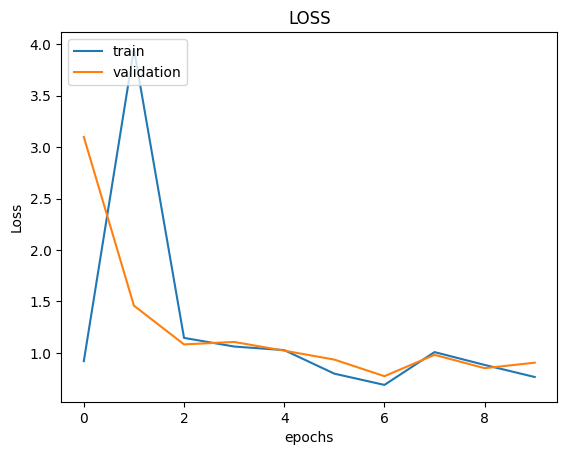

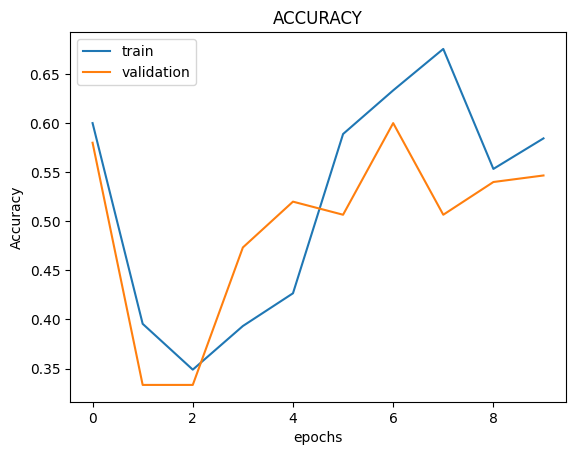

In [22]:
# Training and validation accuracy plots
# TODO: YOUR SOLUTION HERE
utils.get_metric_plots(losses, val_losses, "Loss")


# Training and validation loss plots
# TODO: YOUR SOLUTION HERE
utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")

### Evaluation on the test set

Let's check the test accuracy and confusion matrix. All the required functionality is already provided in `ex3_utils.py` and you just need to read the corresponding functions to understand how to call them here.

In [23]:
# Loading the best model for inference (NOTE: you should load the checkpoints to the expected model architecture, else you might get some mismatch errors)
# TODO: YOUR SOLUTION HERE


# Provide the testing dataset wrapped in a dataloader to check for inference
# TODO: YOUR SOLUTION HERE
correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

Accuracy of /kaggle/working/covid-19-3_class_resnet18-from-scratch.pt on the Test Images: 57 %


In [24]:
# Get the confusion matrix for the test dataset
# TODO: YOUR SOLUTION HERE
cm = utils.get_confusion_matrix(classes, test_loader, model, device)


# See the precision, recall and accuracy per class for the test dataset
# TODO: YOUR SOLUTION HERE
utils.check_precision_recall_accuracy(cm, classes)

COVID19 - recall :  0.94736844  precision :  0.72  accuracy :  0.8933333
NORMAL - recall :  0.45180723  precision :  1.0  accuracy :  0.59555554
PNEUMONIA - recall :  0.0  precision :  0.0  accuracy :  0.6577778


0.5733333333333334


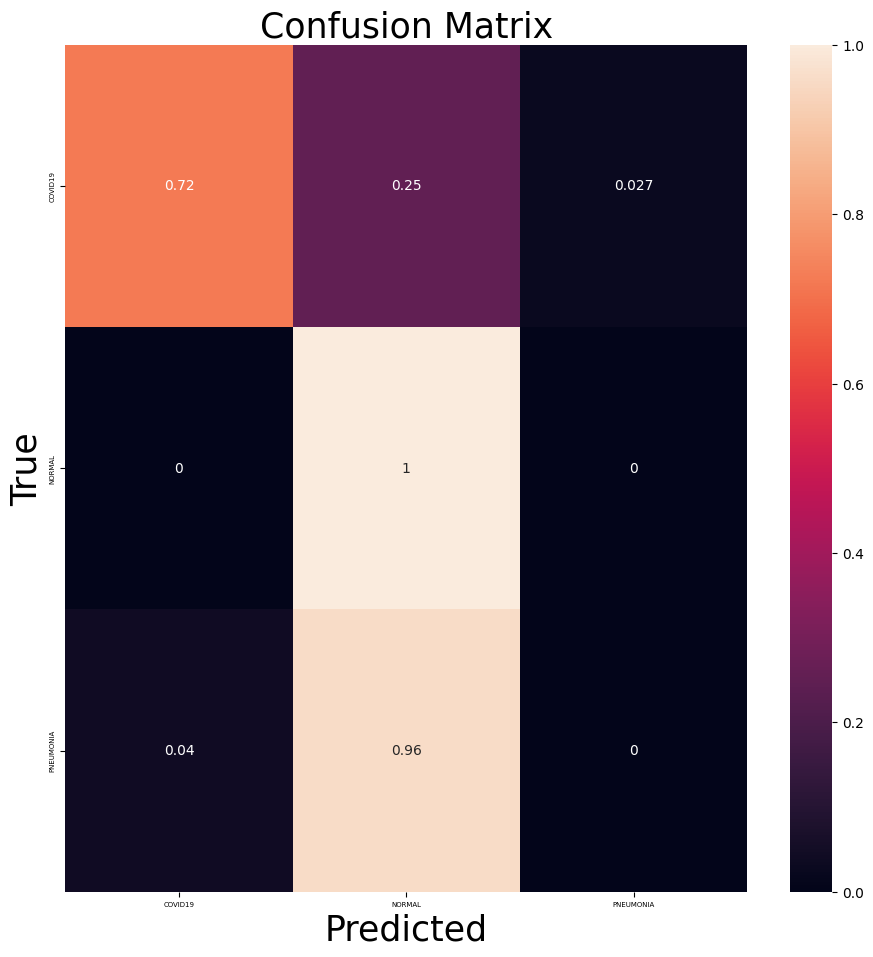

In [25]:
# Check the confusion matrix heatmap to visually see the evaluation on the test set
# TODO: YOUR SOLUTION HERE
utils.visualize_confusion_matrix(cm, classes, correct, total)

Now let's try training deeper ResNet architectures using the same hyperparameters from above:
- Train and evaluate a ResNet34 from scratch.
- Train and evaluate a ResNet50 from scratch.

In [26]:
# TODO: YOUR SOLUTIONS HERE


# HINT: (for the workflow)
#    - Start with training a ResNet34:
#          - Updating the last layers (training the network from scratch)
#          - REMEMBER: Save the respective checkpoints uniquely, and initialize the early stopping with them.
#          - Use the expected hyperparameters for training
#          - Observe the loss and accuracy curves for training and validation
#    - Next, train a ResNet50 (following the same suggestion as above)
#    - Finally, evaluate both the trained models from above on the test set and answer the questions.
model34 = torchvision.models.resnet34()
print(model34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
model34.fc = nn.Linear(in_features=512, out_features=3)
print(model34.fc)

Linear(in_features=512, out_features=3, bias=True)


450/450: [============================>...] - ETA 0.9s
Epoch: 1
Training Loss: 1.150 , Training Accuracy:0.518 => Validation Loss: 66.327, Validation Accuracy: 0.353 
450/450: [============================>...] - ETA 0.9s
Epoch: 2
Training Loss: 11.331 , Training Accuracy:0.320 => Validation Loss: 1.097, Validation Accuracy: 0.280 
450/450: [============================>...] - ETA 0.8s
Epoch: 3
Training Loss: 1.114 , Training Accuracy:0.338 => Validation Loss: 1.158, Validation Accuracy: 0.333 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 0.9s
Epoch: 4
Training Loss: 1.106 , Training Accuracy:0.340 => Validation Loss: 1.061, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 0.9s
Epoch: 5
Training Loss: 1.095 , Training Accuracy:0.336 => Validation Loss: 1.136, Validation Accuracy: 0.347 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 0.9s
Epoch: 6
Training Loss: 1.089 , Training Accu

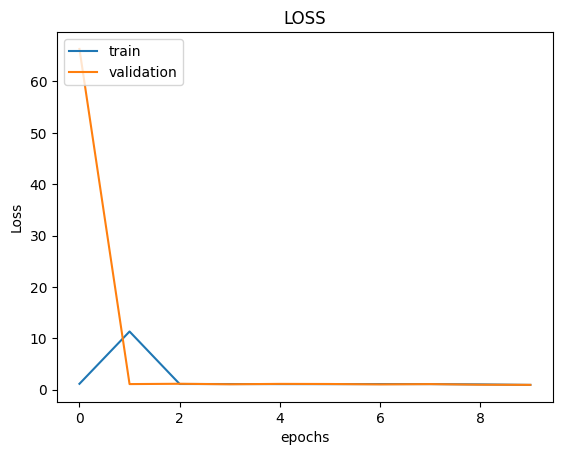

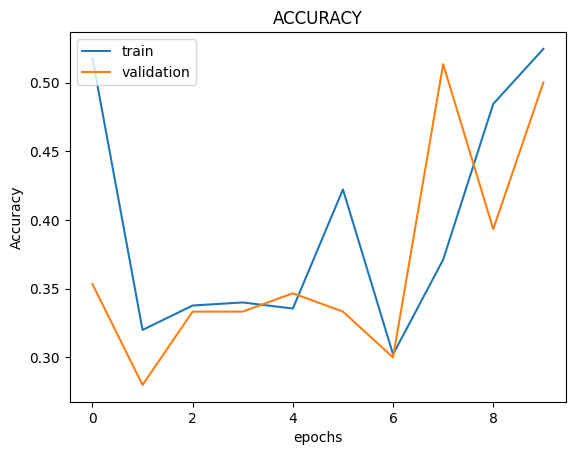

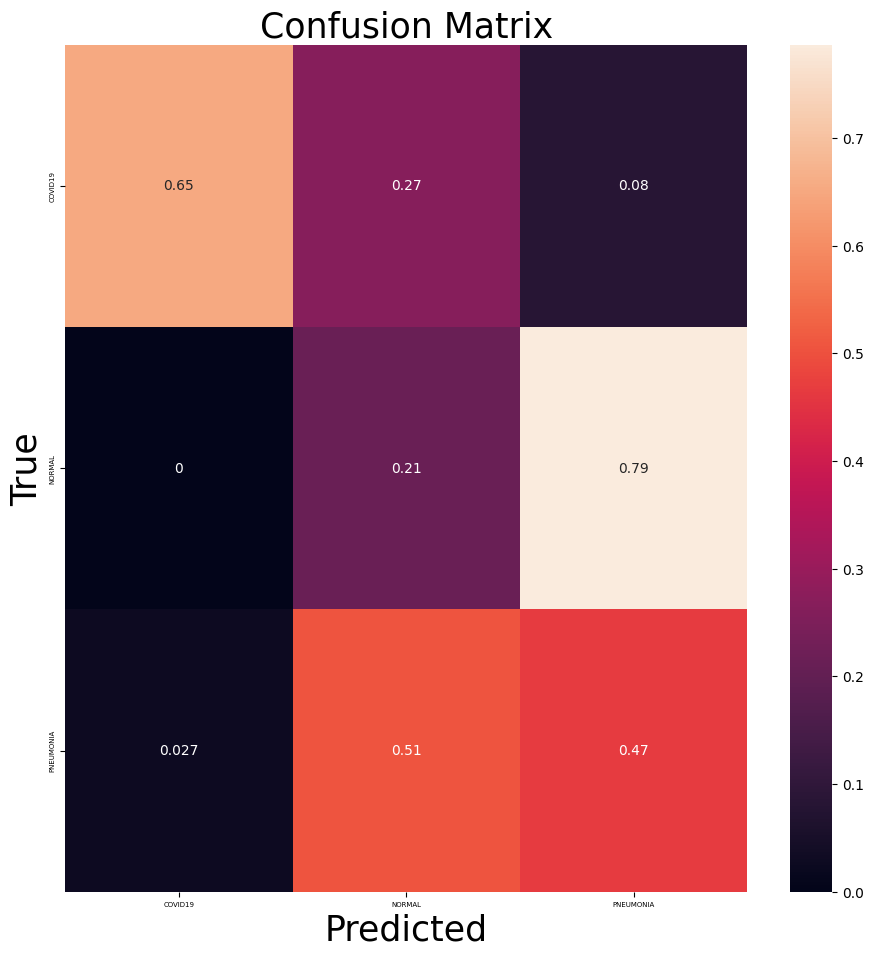

In [28]:
model34.to(device)

model_name = "3_class_resnet34"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)

torch.cuda.empty_cache()

optimizer = torch.optim.Adam(model34.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
early_stopping = utils.EarlyStopping(checkpoint_path)

accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, model34, 10, criterion, optimizer, scheduler=scheduler, early_stopping=early_stopping, device=device)

utils.get_metric_plots(losses, val_losses, "Loss")
utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")


correct, total = utils.test_evaluation(model34, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model34, device)
utils.check_precision_recall_accuracy(cm, classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

In [29]:
model50 = torchvision.models.resnet50()
model50.fc = nn.Linear(in_features=2048, out_features=3)
print(model50.fc)

Linear(in_features=2048, out_features=3, bias=True)


In [30]:
torch.cuda.empty_cache()

450/450: [============================>...] - ETA 1.2s
Epoch: 1
Training Loss: 1.206 , Training Accuracy:0.533 => Validation Loss: 2.276, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 1.0s
Epoch: 2
Training Loss: 3.863 , Training Accuracy:0.304 => Validation Loss: 1.295, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 1.0s
Epoch: 3
Training Loss: 1.221 , Training Accuracy:0.338 => Validation Loss: 1.068, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 1.0s
Epoch: 4
Training Loss: 1.185 , Training Accuracy:0.313 => Validation Loss: 1.202, Validation Accuracy: 0.333 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 1.0s
Epoch: 5
Training Loss: 1.103 , Training Accuracy:0.369 => Validation Loss: 1.089, Validation Accuracy: 0.353 
EarlyStopping Counter: 2 out of 5
450/450: [============================>...] - ETA 1.0s
Epoch: 6
Training Loss: 1.113 , Training Accura

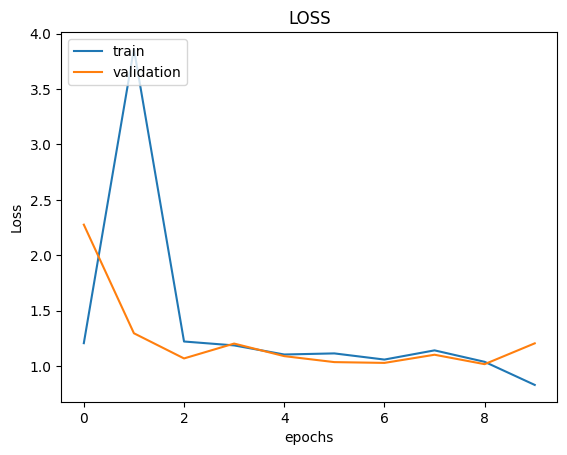

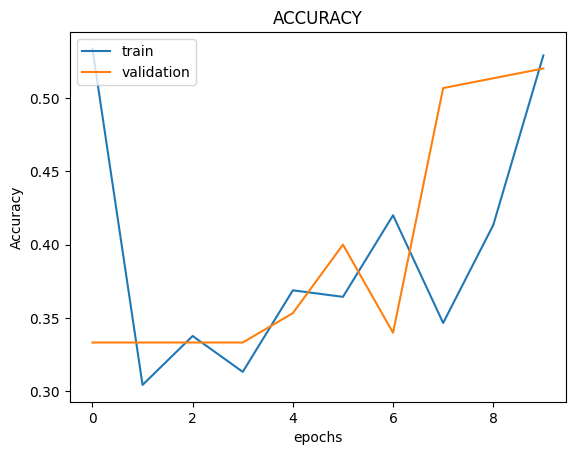

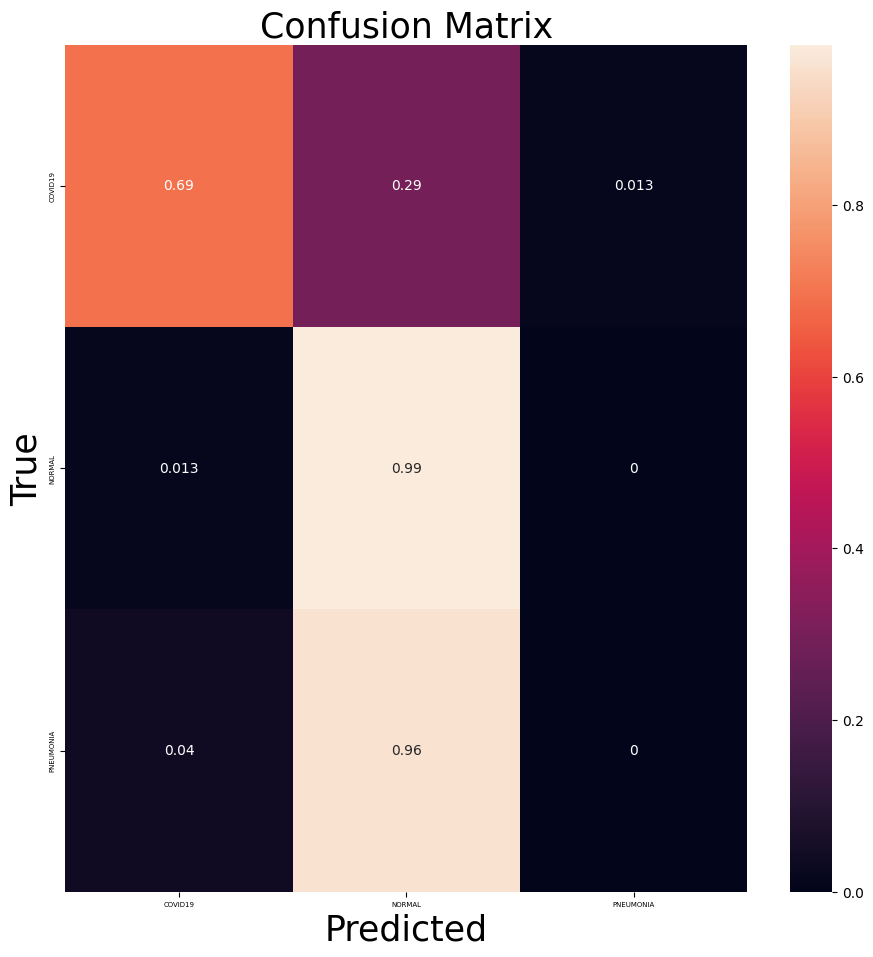

In [31]:
model50.to(device)

model_name = "3_class_resnet50"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model50.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
early_stopping = utils.EarlyStopping(checkpoint_path)

accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, model50, 10, criterion, optimizer, scheduler=scheduler, early_stopping=early_stopping, device=device)

utils.get_metric_plots(losses, val_losses, "Loss")
utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")


correct, total = utils.test_evaluation(model50, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, model50, device)
utils.check_precision_recall_accuracy(cm, classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

**Questions**:

1. How does the performance of the three architectures compare to each other? Are there any specific patterns you can see in the confusion matrices?
2. Is there a correlation between the dataset size and depth of the network?
3. Given these observations, which model would you prefer for training on a small dataset from scratch?

**1. Performance Comparison:**
- **Model 1:** Performs well on "NORMAL" and "PNEUMONIA" but struggles with "COVID19" misclassifications.
- **Model 2:** Balanced performance but struggles more with "NORMAL" misclassification.
- **Model 3:** Best overall balance with fewer misclassifications, especially for "COVID19."

**2. Dataset Size vs. Network Depth:**
- **Smaller datasets:** Shallow networks are better to avoid overfitting.
- **Larger datasets:** Deeper networks can leverage their capacity to learn complex patterns.

**3. Best Model for Small Datasets:**
- A **shallow model** is preferable for small datasets to reduce overfitting and improve generalization.
- 

#### Now let's try with **Data Augmentation**

A common strategy when dealing with small datasets is to add data augmentations.

Let's try a few augmentations from [torchvision.transforms](https://pytorch.org/vision/main/transforms.html) that do not significantly distort the data (stay on the data manifold) and train a ResNet50. Here, we want to see if augmentations allow us to train deeper CNNs. 
Common augmentations for data augmentation are:
- flipping the inputs along the axes.
- changing the brightness, contrast and saturation of the inputs.
- adding small noise to the input.

You can try different combinations of augmentations here. You can add augmentations by updating the `transform` passed to the train dataset. You can again use `Compose` to chain augmentations.

Note; you should only introduce augmentation for the training and validation datasets, **not** for the test dataset. Otherwise the evaluation between models is not consistent anymore.

In [50]:
# TODO: YOUR SOLUTIONS HERE

# HINT:
#    - Training a ResNet50 (incorporating data augmentation strategies)
#    = (the training workflows are the same as above)
aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),               
    transforms.RandomHorizontalFlip(p=0.5),     
    transforms.ColorJitter(brightness=0.2,       
                           contrast=0.2,
                           saturation=0.2),
    transforms.RandomApply([                   
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    ], p=0.2),
    transforms.ToTensor(),                      
    transforms.Normalize(mean=train_dataset_mean, std=train_dataset_std)  
])


We need to apply the new transforms to the dataset and then use our dataloader. Let's reuse our scripts from above, now with the added data augmentation strategies.

In [51]:
# TODO: YOUR SOLUTION HERE
# Datasets
aug_train_dataset = datasets.ImageFolder(root=train_dir, transform=aug_transform)
aug_val_dataset = datasets.ImageFolder(root=val_dir, transform=aug_transform)

# TODO: YOUR SOLUTION HERE
# Dataloaders
aug_train_loader = DataLoader(aug_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
aug_val_loader = DataLoader(aug_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Now, we are ready to train the ResNet50 with data augmentations. Let's train for longer (30 epochs) here, with the same hyperparameters as before, and evaluate the model on the test set.

450/450: [============================>...] - ETA 1.2s
Epoch: 1
Training Loss: 1.798 , Training Accuracy:0.451 => Validation Loss: 2.272, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 1.2s
Epoch: 2
Training Loss: 2.415 , Training Accuracy:0.336 => Validation Loss: 4.206, Validation Accuracy: 0.333 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 1.1s
Epoch: 3
Training Loss: 1.261 , Training Accuracy:0.462 => Validation Loss: 2.597, Validation Accuracy: 0.333 
EarlyStopping Counter: 2 out of 5
450/450: [============================>...] - ETA 1.2s
Epoch: 4
Training Loss: 1.304 , Training Accuracy:0.416 => Validation Loss: 1.082, Validation Accuracy: 0.373 
450/450: [============================>...] - ETA 1.2s
Epoch: 5
Training Loss: 0.931 , Training Accuracy:0.538 => Validation Loss: 1.023, Validation Accuracy: 0.567 
450/450: [============================>...] - ETA 1.2s
Epoch: 6
Training Loss: 0.754 , Training Accura

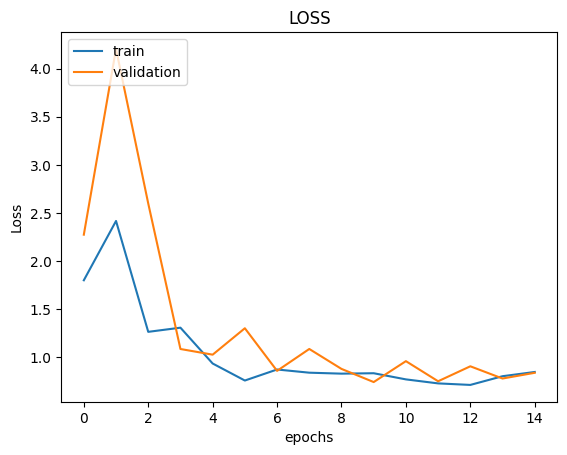

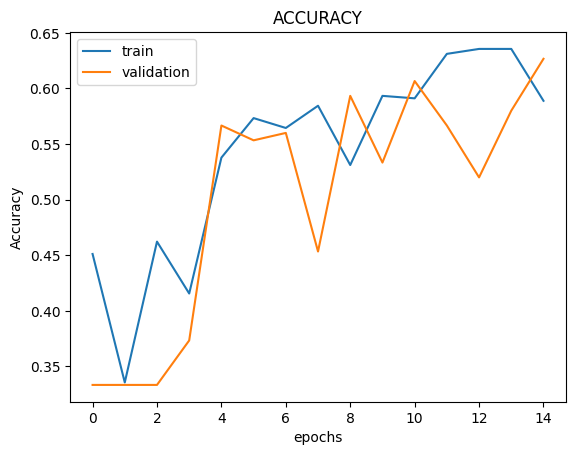

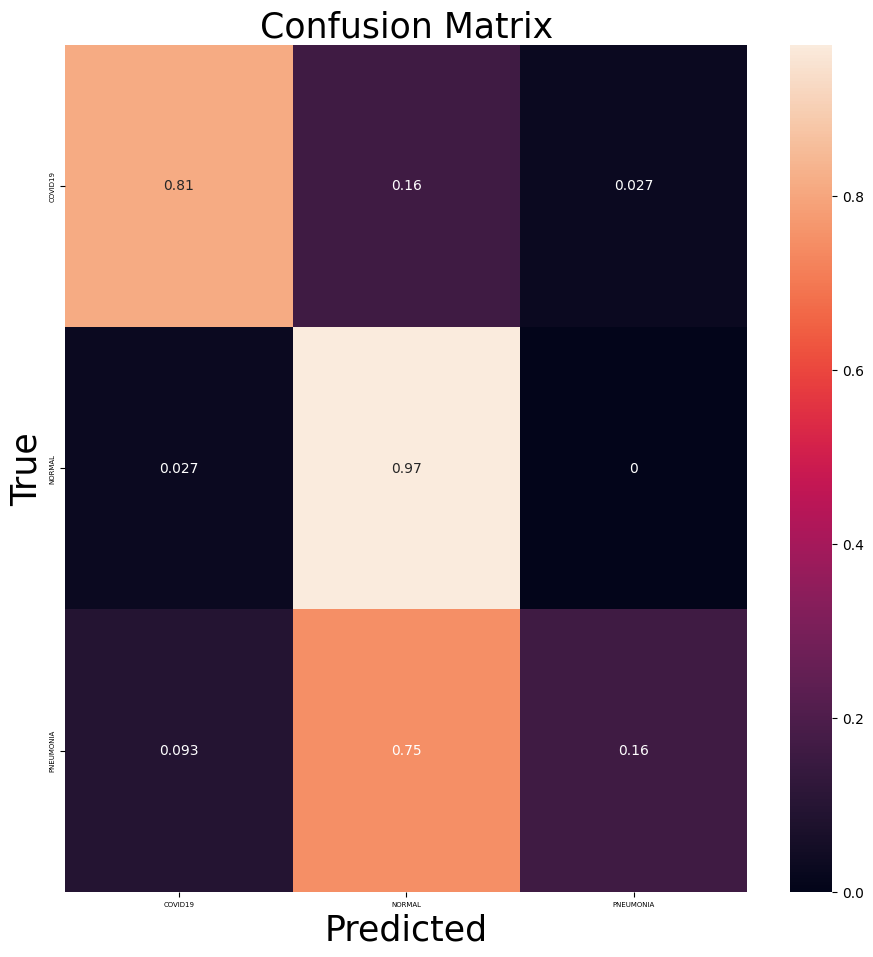

In [52]:
# TODO: YOUR SOLUTION 
aug_model = torchvision.models.resnet50()
aug_model.fc = nn.Linear(in_features=2048, out_features=3)
#print(aug_model.fc)

torch.cuda.empty_cache()

aug_model.to(device)

model_name = "3_class_resnet50_augmented"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(aug_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
early_stopping = utils.EarlyStopping(checkpoint_path)

accuracy, val_accuracy, losses, val_losses = utils.run_training(aug_train_loader, aug_val_loader, aug_model, 30, criterion, optimizer, scheduler=scheduler, early_stopping=early_stopping, device=device)

utils.get_metric_plots(losses, val_losses, "Loss")
utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")


correct, total = utils.test_evaluation(aug_model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, aug_model, device)
utils.check_precision_recall_accuracy(cm, classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

**Questions**:

1. Does the effect of data augmentation match your expectation?
2. Are there other kinds of data augmentation that would make sense for this dataset? Think about augmentations that "leave the data manifold".


**1. Does the effect of data augmentation match expectations?**
- **Positive:** Improved recall for COVID-19 (87.1%) and Pneumonia (85.7%).
- **Negative:** Poor precision for Pneumonia (16%) and low recall for NORMAL (51.7%).
- **Conclusion:** Augmentation helped some classes but didn’t fully improve generalization.

---

 **2. Recommended Augmentations**
**On-Manifold (Safe):**
- Small **rotations** and **flipping**.
- **Contrast adjustments** for equipment variation.
- **Zooming/cropping** for region variability.
- **Noise injection** to simulate real-world conditions.


## ImageNet

The [ImageNet project](https://www.image-net.org/) provides a large-scale dataset with natural images. There exist different version of this dataset, the largest using 14 million annotated images for image classification with over 20,000 categories. 

This dataset has been used by the ImageNet Scale Visual Recognition Challenge ([ILSVRC](https://image-net.org/challenges/LSVRC/#:~:text=The%20ImageNet%20Large%20Scale%20Visual,image%20classification%20at%20large%20scale.)) to benchmark classification algorithms competing to improve classification. The version fo the dataset used for this classification contains a million training images with 1,000 categeories (and corresponds to the version fo the dataset we discussed in the lecture).

`torchvision.models` has a pool of neural networks, for which pretrained ImageNet weights are also available. To make use of pretrained models, we need to preprocess the images based on the mean and standard deviation of ImageNet (this step is critical!). The statistics for ImageNet are provided [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#:~:text=1.0%5D%20and%20then-,normalized%20using%20mean%3D%5B0.485%2C%200.456%2C%200.406%5D%20and%20std%3D%5B0.229%2C%200.224%2C%200.225%5D.,-Next).

### ImageNet transfer learning for ResNet50

We will now check if transfer learning from ImageNet leads to improvements for our dataset. Here, we will focus on the ResNet50 as we have seen before that without transfer learning its performance is worse compared to smaller architectures for our dataset.

There are two different approaches for how we can fine-tune a CNN initialized with pretrained weights:
1. Update the weights for all layers of the network. For this approach we initialize with pretrained weights but otherwise train the network as before. See this code snippet:
   
    ```python
    import torchvision
    import torch.nn as nn

    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

    # Let's replace the "fully connected" layer to match our expected output classes
    model.fc = nn.Linear(<INPUT_FEATURES>, <OUTPUT_CLASSES>)
    model.to(device)

    # Train the network as usual
    ```

2. Only update the weights of the last layer (classification layer). In this case we would "freeze" the pretrained network and use it as a fixed feature extractor. This is achieved by disabling parameter updates for all but the last layer of the network.

We will start with the first approach (fine-tuning the full network).

450/450: [============================>...] - ETA 1.1s
Epoch: 1
Training Loss: 0.433 , Training Accuracy:0.816 => Validation Loss: 1.196, Validation Accuracy: 0.813 
450/450: [============================>...] - ETA 1.0s
Epoch: 2
Training Loss: 2.681 , Training Accuracy:0.389 => Validation Loss: 1.320, Validation Accuracy: 0.333 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 1.1s
Epoch: 3
Training Loss: 1.220 , Training Accuracy:0.304 => Validation Loss: 1.085, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 1.0s
Epoch: 4
Training Loss: 1.112 , Training Accuracy:0.351 => Validation Loss: 1.074, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 1.0s
Epoch: 5
Training Loss: 1.067 , Training Accuracy:0.424 => Validation Loss: 1.048, Validation Accuracy: 0.440 
450/450: [============================>...] - ETA 1.0s
Epoch: 6
Training Loss: 1.022 , Training Accuracy:0.551 => Validation Loss: 0.992

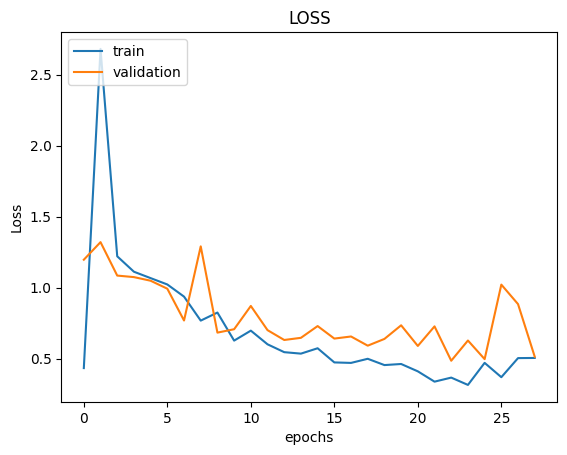

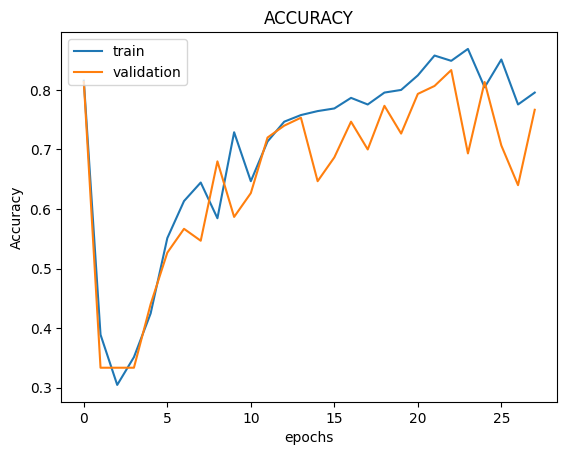

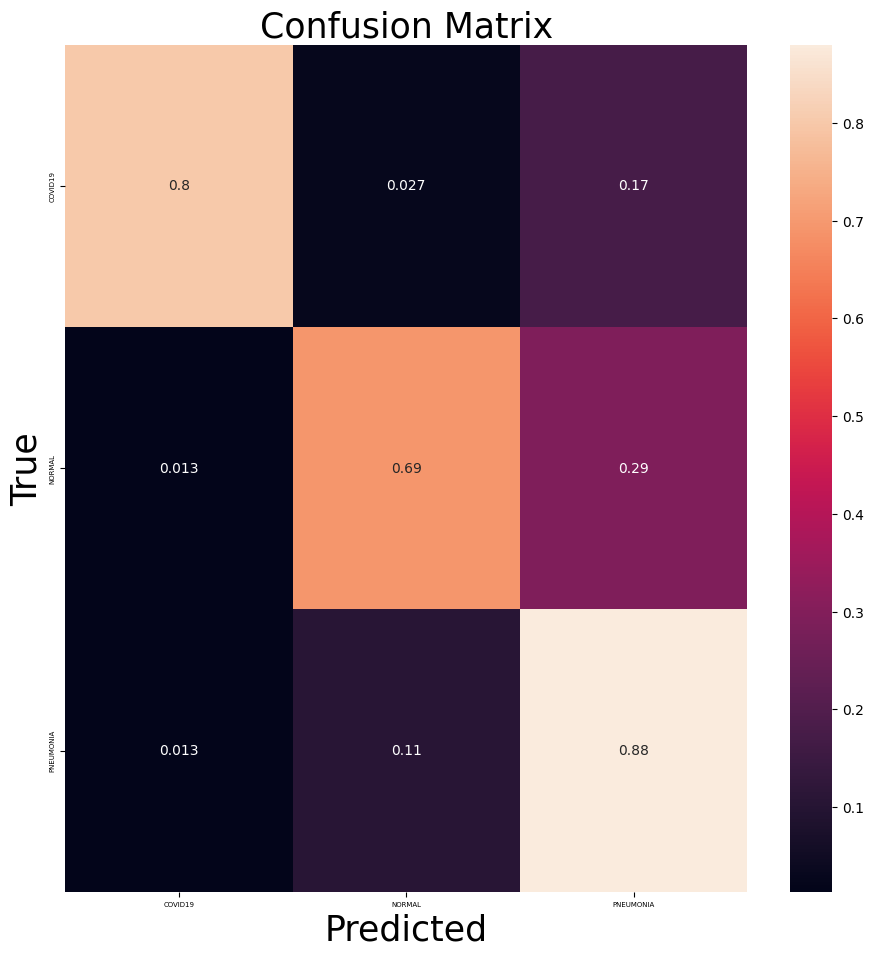

In [55]:
# TODO: YOUR SOLUTIONS HERE

# HINT:
#    - Training a ResNet50 (updating all the layers, transfer learning using ImageNet weights)
#    = (the training workflows are the same as above)
init_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
init_model.fc = nn.Linear(in_features=2048, out_features=3)
#print(init_model.fc)

torch.cuda.empty_cache()

init_model.to(device)

model_name = "3_class_resnet50_initalized"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(init_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
early_stopping = utils.EarlyStopping(checkpoint_path)

accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, init_model, 30, criterion, optimizer, scheduler=scheduler, early_stopping=early_stopping, device=device)

utils.get_metric_plots(losses, val_losses, "Loss")
utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")


correct, total = utils.test_evaluation(init_model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, init_model, device)
utils.check_precision_recall_accuracy(cm, classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

Now let's try the second approach and finetune only the last layer.

By default all parameters of a network will be updated by gradient descent. The gradient updates can be disabled by setting `requires_grad = False`. So in order to finetune only the last layer you need to `requires_grad = False` for all other layers in the network.

You can see how the parameters are disabled for a complete model in the code snippet below. For the next exercise you need to make sure that `requires_grad` stays `True` for the last layer!

```python
for param_name, param in model.named_parameters():
    param.requires_grad = False
```

450/450: [============================>...] - ETA 0.8s
Epoch: 1
Training Loss: 1.038 , Training Accuracy:0.491 => Validation Loss: 0.980, Validation Accuracy: 0.727 
450/450: [============================>...] - ETA 0.8s
Epoch: 2
Training Loss: 0.947 , Training Accuracy:0.722 => Validation Loss: 0.851, Validation Accuracy: 0.880 
450/450: [============================>...] - ETA 0.8s
Epoch: 3
Training Loss: 0.769 , Training Accuracy:0.869 => Validation Loss: 0.763, Validation Accuracy: 0.860 
450/450: [============================>...] - ETA 0.8s
Epoch: 4
Training Loss: 0.668 , Training Accuracy:0.822 => Validation Loss: 0.675, Validation Accuracy: 0.867 
450/450: [============================>...] - ETA 0.8s
Epoch: 5
Training Loss: 0.570 , Training Accuracy:0.871 => Validation Loss: 0.563, Validation Accuracy: 0.887 
450/450: [============================>...] - ETA 0.8s
Epoch: 6
Training Loss: 0.491 , Training Accuracy:0.911 => Validation Loss: 0.516, Validation Accuracy: 0.927 
450/

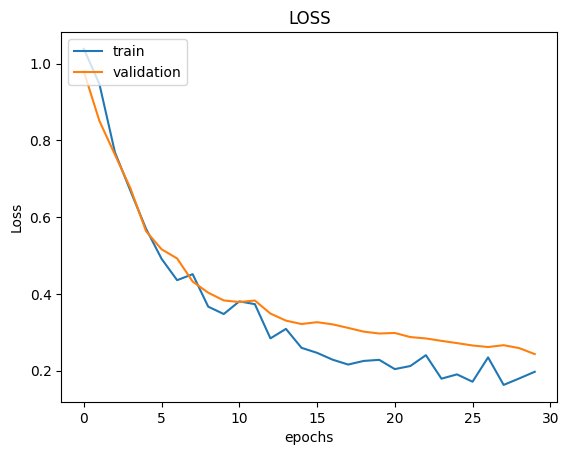

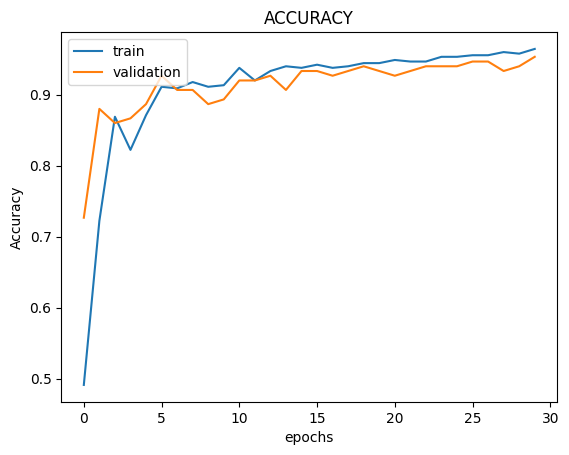

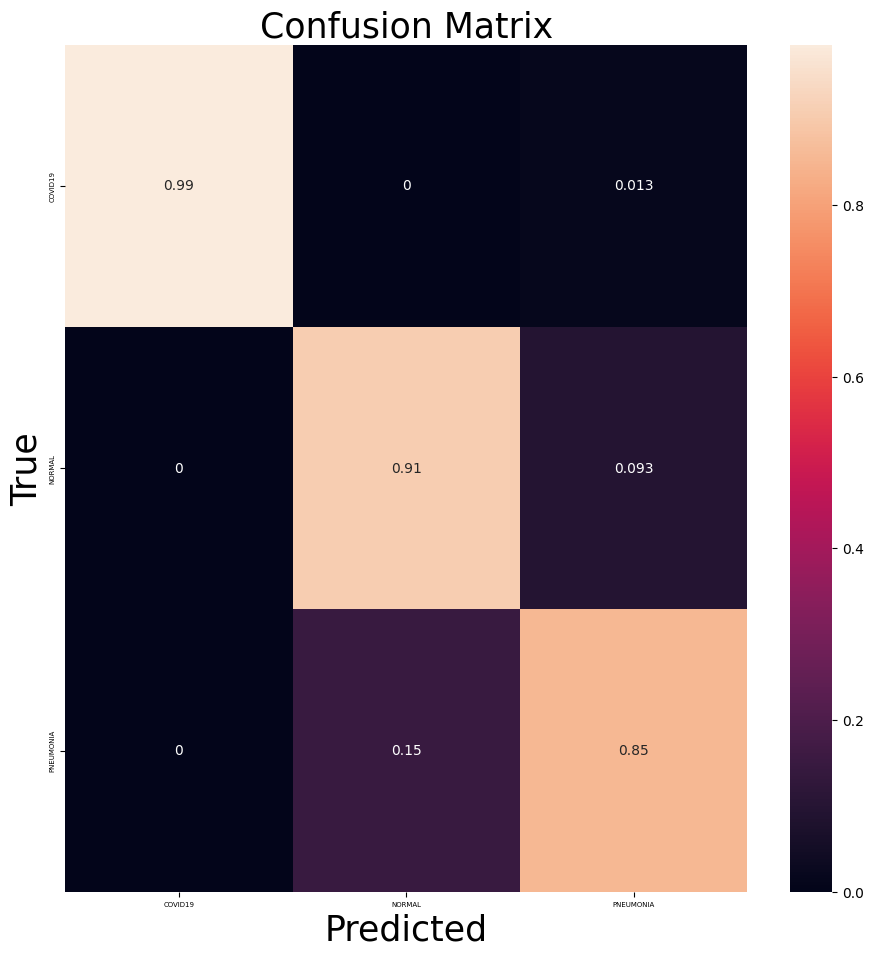

In [57]:
# TODO: YOUR SOLUTIONS HERE

# HINT:
#    - Training a ResNet50 (updating the last layers, transfer learning using ImageNet weights)
#    = (the training workflows are the same as above)
# TODO: YOUR SOLUTIONS HERE

# HINT:
#    - Training a ResNet50 (updating all the layers, transfer learning using ImageNet weights)
#    = (the training workflows are the same as above)
freez_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
freez_model.fc = nn.Linear(in_features=2048, out_features=3)
#print(freez_model.fc)

for param_name, param in freez_model.named_parameters():
    # if "fc" not in param_name:
    param.requires_grad = False

for param in freez_model.fc.parameters():
    param.requires_grad = True

torch.cuda.empty_cache()

freez_model.to(device)

model_name = "3_class_resnet50_initalized"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(freez_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
early_stopping = utils.EarlyStopping(checkpoint_path)

accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, freez_model, 30, criterion, optimizer, scheduler=scheduler, early_stopping=early_stopping, device=device)

utils.get_metric_plots(losses, val_losses, "Loss")
utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")


correct, total = utils.test_evaluation(freez_model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, freez_model, device)
utils.check_precision_recall_accuracy(cm, classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

**Questions**:

1. Elaborate on the reason to use pretrained ImageNet weights for transfer learning (instead of training from scratch).
2. Which transfer learning approach performs better for finetuning on our dataset? Comment on the possible reasons!
3. Explain the best use-cases for ImageNet pretrained weights for the two different approaches (i.e. when it is a good idea to train from scratch OR for finetuning all layers OR for finetuning last layers).

1. Pretrained ImageNet weights provide a strong initialization, leveraging features learned from a large, diverse dataset. This saves time and computational resources compared to training from scratch, especially for small datasets. The general features learned (e.g., edges and textures) are transferable to various visual tasks, improving performance and avoiding overfitting.
2. Fine-tuning all layers is better for large datasets that differ significantly from ImageNet, as it allows the model to learn domain-specific features. Fine-tuning only the last layers works well for small datasets with some similarity to ImageNet, reducing overfitting. Training from scratch is ideal for very large, unique datasets where ImageNet features are not relevant.

**Comment:** When finetuning a model it may also be beneficial to use a different learning rate and change other hyperparameters compared to training from scratch. To keep the exercise simple we do not further explore these options here. If you're interested to investigate these effects you can explore different hyperparameters at the end of the exercise.

## RadImageNet

A disadvantage of using ImageNet pretraining for medical images is that the pretraining data is very different to medical images. There are several efforts to build pretraining datasets for the medical image domain, for example [RadImageNet](https://www.radimagenet.com/).
It contains a pretraining dataset made up of radiology images of a comparable size to ImageNet and provides networks that were pretrained with this dataset.
- For more details you can check out the [RadImageNet publication](https://doi.org/10.1148/ryai.210315).

Note: if you use on RadImageNet weights you will have to use the statistics below for normalization (corresponding to the image statistics of the RadImageNet dataset):
```python
# Normalization: mean and standard deviation values for the pretrained weights on RadImageNet dataset
radimagenet_mean = (0.223, 0.223, 0.223)
radimagenet_std = (0.203, 0.203, 0.203)
```

We now use pretrained RadImageNet weights for the ResNet50. For this we first need to download those weights and then initialize the architecture correctly. (This is a bit more complex compared to before, so we give you the code for this below.)

In [58]:
# DO NOT CHANGE
# downloading the RadImageNet pretrained model weights
# RadImageNet weights: https://drive.google.com/file/d/1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR/view
! gdown 1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR

!unzip -q "/kaggle/working/RadImageNet_pytorch.zip" -d "RadImageNet_Models"

Downloading...
From (original): https://drive.google.com/uc?id=1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR
From (redirected): https://drive.google.com/uc?id=1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR&confirm=t&uuid=4bc8caa1-a0e0-4a71-b439-c73e9e5f12f7
To: /kaggle/working/RadImageNet_pytorch.zip
100%|█████████████████████████████████████████| 195M/195M [00:00<00:00, 212MB/s]
replace RadImageNet_Models/RadImageNet_pytorch/DenseNet121.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [59]:
# DO NOT CHANGE
radimagenet_checkpoint_path = "/kaggle/working/RadImageNet_Models/RadImageNet_pytorch"

resnet50_ckpt = torch.load(os.path.join(radimagenet_checkpoint_path, "ResNet50.pt"))

/tmp/ipykernel_30/70626612.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50_ckpt = torch.load(os.path.join(radimagenet_checkpoint_path, "ResNet50.pt"))


In [60]:
# DO NOT CHANGE
# We create the backbone to intialize it with the pretrained weights from RadImageNet
class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = torchvision.models.resnet50()
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:9])
                        
    def forward(self, x):
        return self.backbone(x)


# We build the classifier to use the features for transfer learning
class Classifier(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.drop_out = nn.Dropout()
        self.linear = nn.Linear(2048, num_class)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear(x)
        return x

## Architecture

We now combine the backbone (ResNet50 pretrained on RadImageNet) and the classification layer for our dataset.

Train and evaluate this model. You can decide whether to finetune the whole model or just the last layer.

In [61]:
# Let's call the backbone (the encoder excluding the last layers)
backbone = Backbone()

# Loading the pretrained weights to the backbone
backbone.load_state_dict(resnet50_ckpt)

# Now let's call the expected fully connected layer
classifier = Classifier(num_class=len(classes))

# Finally, we are ready to build our model 
net = nn.Sequential(backbone, classifier).to(device)

450/450: [============================>...] - ETA 0.8s
Epoch: 1
Training Loss: 1.027 , Training Accuracy:0.433 => Validation Loss: 1.019, Validation Accuracy: 0.360 
450/450: [============================>...] - ETA 0.8s
Epoch: 2
Training Loss: 1.016 , Training Accuracy:0.338 => Validation Loss: 0.987, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 0.8s
Epoch: 3
Training Loss: 1.064 , Training Accuracy:0.333 => Validation Loss: 0.948, Validation Accuracy: 0.413 
450/450: [============================>...] - ETA 0.8s
Epoch: 4
Training Loss: 0.949 , Training Accuracy:0.729 => Validation Loss: 1.003, Validation Accuracy: 0.647 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 0.8s
Epoch: 5
Training Loss: 0.953 , Training Accuracy:0.651 => Validation Loss: 0.958, Validation Accuracy: 0.673 
EarlyStopping Counter: 2 out of 5
450/450: [============================>...] - ETA 0.8s
Epoch: 6
Training Loss: 0.842 , Training Accura

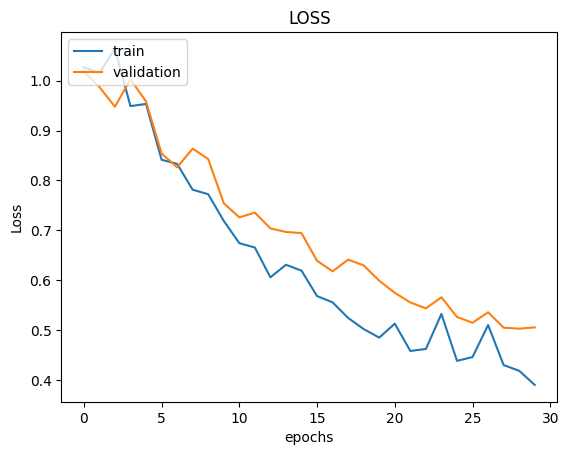

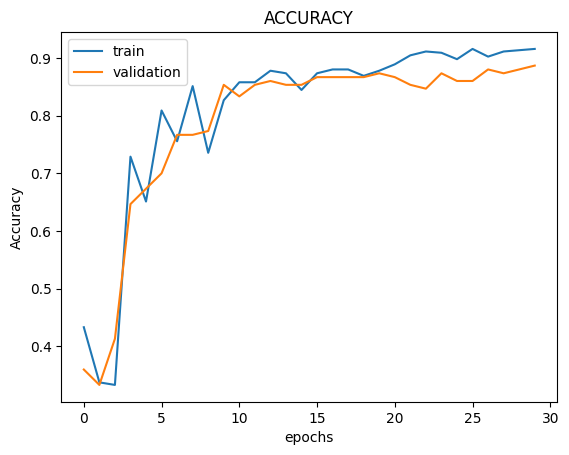

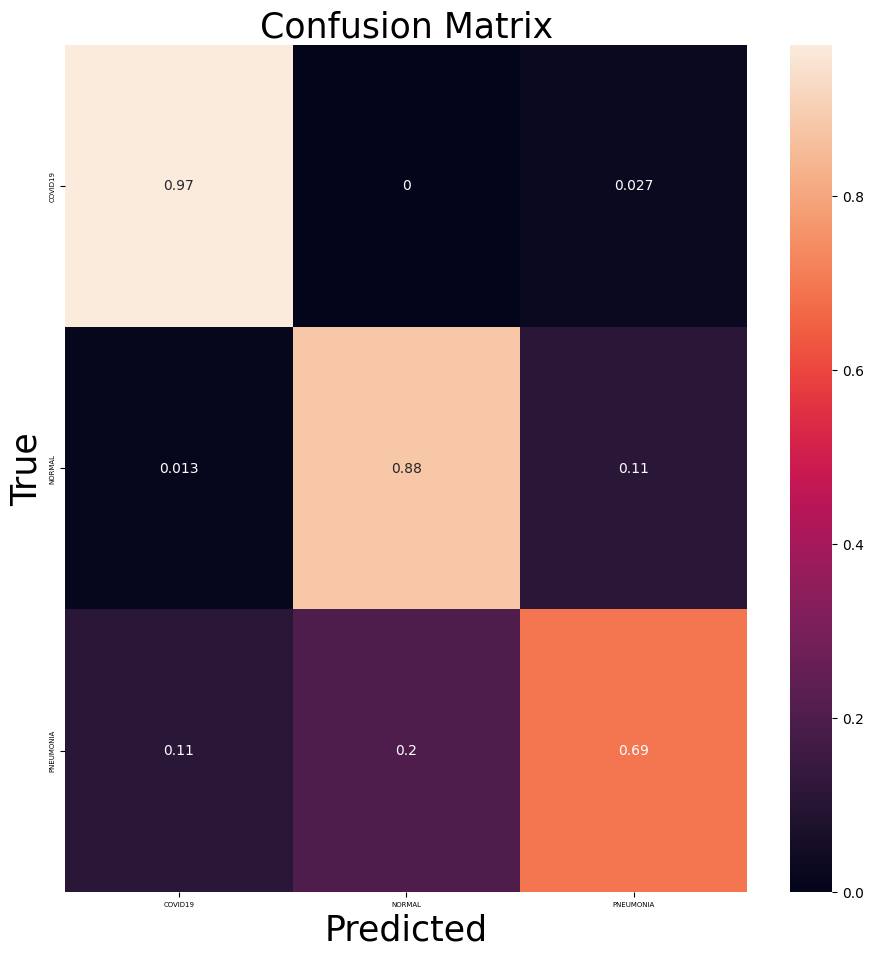

In [62]:
# TODO: YOUR SOLUTIONS HERE

# HINT:
#    - Training a ResNet50 (updating all / last layers, transfer learning using RadImageNet weights)
#    = (the training workflows are the same as above)
torch.cuda.empty_cache()

for param_name, param in net[0].named_parameters():
    param.requires_grad = False

model_name = "3_class_resnet50_backbone"
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
early_stopping = utils.EarlyStopping(checkpoint_path)

accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, net, 30, criterion, optimizer, scheduler=scheduler, early_stopping=early_stopping, device=device)

utils.get_metric_plots(losses, val_losses, "Loss")
utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")


correct, total = utils.test_evaluation(net, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

cm = utils.get_confusion_matrix(classes, test_loader, net, device)
utils.check_precision_recall_accuracy(cm, classes)
utils.visualize_confusion_matrix(cm, classes, correct, total)

**Questions**:

1. Comment on your choice of transfer learning approach (either finetuning last layers / all layers in the model) for RadImageNet? Why could the best approach here be different from ImageNet?

### Overall Results:

Update the table with your results for all experiments from the exercise:

| Model    | Training                         | Test Accuracy |
|:-------: |:--------------------------------:|:-------------:|
| ResNet18 | from scratch                     |    57%        |
| ResNet34 | from scratch                     |    44%        |
| ResNet50 | from scratch                     |    56%        |
| ResNet50 | from scratch (with augmentation) |    64%        |
| ResNet50 | from ImageNet (all layers)       |    79%        |
| ResNet50 | from ImageNet (last layers)      |    91%        |
| ResNet50 | from RadImageNet                 |    84%        |

**Question**:
1. Comment on the trend observed in the results from the table.
2. Which is the overall best model? Does this match your expectations? Why/why not?

**Important: Please read the end of the exercise sheet and upload the predictions from your best model, also if you choose not to try out to further improve it.**

## Further improve your model (*Optional*)

You can now try to further improve the model by using different architectures or trying some of the advanced training and inference techniques discussed in the lecture. This part of the exercise is optional, and you can try to apply as many approaches for improving your method as you would like. If you don't want to work on the optional part at all please go to the end of the exercise to submit the predictions from your best model.

Here are the aproaches you can try to improve the model:
1. Update the training hyperparameter:
    - You can choose a better initial learning rate, or choose different options for the learning rate scheduler or early stopping.
    - The most important parameter is probably the learning rate; if you want to improve it then train only for a short time and compare different values. (Remember lecture 2 and the first exercise). 
2. Try other architectures provided in `torchvision.models`, which implements further CNN architectures (and their respective ImageNet pretrained weights). For example `DenseNet` or `EfficientNet` could yield better results than ResNets.
    - `torchvision.models` also offers vision transformer architectures (https://arxiv.org/abs/2010.11929). We will cover those later in the lecture, but if you want you can try them here as well. See the snippet at the end of this section for details. 
3. Try advanced data augmentation strategies, which change the data manifold severly and can boost performance. For example MixUp or CutMix. `torchivsion` already implements them, see [data augmentation with torchvision](https://pytorch.org/vision/stable/transforms.html) for details.
4. Try test-time data augmentation. We have covered this idea in the lecture. To use it you don't need to change the training at all, but just update the model prediction during testing. Fot this you can either update the functionality in `ex3_utils.py` or implement a wrapper function or class around the model that implements the test-time data augmentation logic.
5. Try model ensembling: combine the predictions of different models on the test set or use an implicit averaging approach like polyak averaging. For this approaches you may need to update the training and/or prediction functions from `ex3_utils.py`.

Here's a snippet that shows how to use vision transformers from torchvision:

```python
# replacing the respective layers of the "transformer-based networks" to match our number of classes
net = torchvision.models.vit_b_16(pretrained=True)
net.heads.head = nn.Linear(768, num_classes)
net.to(device)
```

**Hint**: if you want to systematically improve your model you should proceed as follows:
- Decide on the base architecture and how to initialize it.
    - Either choose the best model you according to the exercise so far or try if advanced architectures from `torchvision` bring an improvement and continue with one of them.
- Optimize the training hyperparameters (learning rate, scheduling, early stopping).
- Investigate advanced techniques:
  - Training with more or advanced data augmentation.
  - Test-time data augmentation
  - Model ensembling

You can divide some of these tasks up among your group and train the best model by combining the best settings you have found for the individual steps.

## Train your best model

In [42]:
# TODO: IMPLEMENT AND TRAIN THE BEST MODEL HERE

## Submission:

- The `unknown` set corresponds to a hold-out test set (with unlabeled images). Such unseen test data is common in machine learning challenges to ensure an objective comparison of different methods and to test how well these solutions would generalize to real data.
- Submit the predictons for the `unknown` set using your best model together with your exercise solution.
    - Upload the solutions to `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 3` -> `Challenge Results`-> `Tutorial <X>`.
    - Your submission should be called `results_surname1_surname2_surname3.csv`. The expected file format is described below and we provide a function that generates these results for you already.
- **Please submit the results from your best model (or the model you expect to perform best). If you don't work on the optional part of the exercise then submit the best result from the models you have trained so far.**
    - The group with the best submission will get a small prize ;-) 

### Expected Submission Format

Before submitting your results, please make sure that they are in the below mentioned format:
- `results_<surname1>_<surname2>_<surname3>.csv`
    - patient_\<ID-1>.jpg | \<CLASS-1>
    - patient_\<ID-2>.jpg | \<CLASS-2> <br>
    . <br>
    . <br>
    . <br>
    - patient_\<ID_n>.jpg | \<CLASS-[1-3]>
 
We have prepared a function that generates these predictions for you (see below).

In [43]:
# TODO: YOUR SOLUTION HERE
filename = "results.csv"

# Function generating predictions (in a csv file) for the respective images in the hold-out test set (`unknown` folder)
# Note: if you want to use test-time-augmentation or model ensembling you may need to update this function.
# If you don't want to update it you can also create a new class that implements a wrapper around the model(s)
# that implements the augmentation or ensembling logic.
utils.predict_unknown(net, height, width, train_dataset_mean, train_dataset_std, unknown_dir, device, filename)

# Download link is automatically generated for the final results generated
FileLink(filename)

100%|██████████| 5607/5607 [01:09<00:00, 80.41it/s]


/kaggle/working/results.csv